<a href="https://colab.research.google.com/github/Iswarya2003/Fake_News_Detection/blob/main/Detect_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import urllib
import json

def load_convert_data(url):
    """
    Downloads the json file from net and convert into pandas dataframe format.
    """
    with urllib.request.urlopen(url) as url:
        df = json.loads(url.read().decode())
        df = pd.DataFrame.from_dict(df)
        
    return df

In [ ]:
# Real news data
real_train = load_convert_data("https://storage.googleapis.com/public-resources/dataset/real_train.json")
real_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/real_test.json")

In [ ]:
# Fake news data
fake_train = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_train.json")
fake_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")

In [ ]:
# quick look on real news training data
real_train.head()

,url,title,text
0,https://www.thetimes.co.uk/edition/scotland/sc...,Scots GPs told not to meet fever patients as f...,Scots GPs told not to meet fever patients as f...
1,https://www.bbc.com/news/world-africa-52103799,Coronavirus : Fighting al - Shabab propaganda ...,Coronavirus: Fighting al-Shabab propaganda in ...
2,https://www.thetimes.co.uk/edition/business/en...,Engineer fears China virus impact,Engineer fears China virus impact\nA British e...
3,https://www.theguardian.com/world/live/2020/fe...,Coronavirus : South Korean PM vows swift act...,Here’s a summary of what’s happened so far on ...
4,https://yle.fi/uutiset/osasto/news/finnair_iss...,Finnair issues profit warning over Covid - 19 ...,Finnair issues profit warning over Covid-19 fe...


In [ ]:
# Quick look on Fake news training data
fake_train.head()

,url,title,text,label
0,https://nabd.com/s/71539812-b7228b/%D9%86%D8%B...,Online Facts New conspiracy theory: #Bel_Gates...,Roger Stone suggested on Monday that Bill Gate...,1
1,https://shamra.sy/news/article/8eb73454931e6d1...,Revolutionary Guards: Corona could be an Ameri...,Source\nRussia Today |\nIranian Revolutionary ...,1
2,https://sudanewsnow.com/19800/,Yellow skin is the host environment of the vir...,Sudan news now from all sources sudanewsnow.co...,1
3,https://arabic.rt.com/press/1100276-%D8%A7%D9%...,China and Russia are doing what the European U...,China and Russia are doing what the European U...,1
4,https://www.kachaf.com/details.php?n=5e8957fe1...,,Fatal error: Uncaught MongoDB\Driver\Exception...,1


In [ ]:
real_train['label'] = 0
real_test['label'] = 0
fake_train['label'] = 1
fake_test['label'] = 1

train = pd.concat([real_train, fake_train], ignore_index=True)
test = pd.concat([real_test, fake_test], ignore_index=True)

In [ ]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

train['text'] = train['text'].apply(clean_txt)
test['text'] = test['text'].apply(clean_txt)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)

In [ ]:
def get_split(text):
    """
    Split each news text to subtexts no longer than 150 words.
    """
    l_total = []
    l_parcial = []
    if len(text.split())//120 >0:
        n = len(text.split())//120
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:150]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*120:w*120 + 150]
            l_total.append(" ".join(l_parcial))
    return l_total

train['text_split'] = train['text'].apply(get_split)
val['text_split'] = val['text'].apply(get_split)
test['text_split'] = test['text'].apply(get_split)

In [ ]:
train['text_split'][1]

['coronavirus fighting al shabab propaganda in somalia muslim clerics in conflict hit somalia are moving to the front line of the battle against coronavirus in a bid to counter the propaganda of militant islamists writes bbc somalia analyst mary harper the al qaeda linked al shabab group has warned muslims to beware of infectious diseases such as coronavirus which it says are spread by the crusader forces who have invaded the country and the disbelieving countries that support them the militants control much of southern and central somalia and have been a powerful force for well over a decade although there have only been a handful of confirmed cases of coronavirus in somalia so far the authorities are deeply worried that if the disease takes hold they will be unable to cope koranic schools shut about 30 years of conflict have devastated health facilities hundreds of thousands of displaced people',
 'that if the disease takes hold they will be unable to cope koranic schools shut about 

In [ ]:
def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['text_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'text':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' texts.')
    return new_df

train_df = data_augumentation(train, df_name = 'training')
val_df = data_augumentation(val, df_name  = 'validation')
test_df = data_augumentation(test, df_name = 'testing')

The training set now has 5621 subtexts extracted from 1280 texts.
The validation set now has 1305 subtexts extracted from 320 texts.
The testing set now has 1568 subtexts extracted from 400 texts.


In [ ]:
!pip install bert-for-tf2
import math 
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

     |████████████████████████████████| 40kB 3.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=96fcae4884cc8310cedef05af760d4fec8c71cef42b864365c753c52b505fb67
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=84afbe4b48d5ecfdc45e32b65e761d742b19c79280a295cc4ec76ee6db2a5ce1
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=d1dbc07378df7fa76be23129a2324910081694db977c1980414603d02a1b2add
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
%%time

bert_ckpt_dir="gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/"
bert_ckpt_file = bert_ckpt_dir + "bert_model.ckpt"
bert_config_file = bert_ckpt_dir + "bert_config.json"

bert_model_dir="2018_10_18"
bert_model_name="uncased_L-12_H-768_A-12"

!mkdir -p .model .model/$bert_model_name

for fname in ["bert_config.json", "vocab.txt", "bert_model.ckpt.meta", "bert_model.ckpt.index", "bert_model.ckpt.data-00000-of-00001"]:
  cmd = f"gsutil cp gs://bert_models/{bert_model_dir}/{bert_model_name}/{fname} .model/{bert_model_name}"
  !$cmd

!ls -la .model .model/$bert_model_name

bert_ckpt_dir = os.path.join(".model/",bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_config.json...
/ [1 files][  313.0 B/  313.0 B]                                                
Operation completed over 1 objects/313.0 B.                                      
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/vocab.txt...
/ [1 files][226.1 KiB/226.1 KiB]                                                
Operation completed over 1 objects/226.1 KiB.                                    
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.meta...
/ [1 files][883.0 KiB/883.0 KiB]                                                
Operation completed over 1 objects/883.0 KiB.                                    
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.index...
/ [1 files][  8.3 KiB/  8.3 KiB]                                                
Operation completed over 1 objects/8.3 KiB.                                      
Copying gs://bert_models/2

In [ ]:
class FakeNewsData:
    """
    Preprocessing text into BERT features.

    max_seq_len: Maximum sequence length specified
    tokenizer: BERT tokenizer
    """
    DATA_COLUMN = "text"
    LABEL_COLUMN = "label"

    def __init__(self, tokenizer, train, validation, test, max_seq_len = 150):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        ((self.train_x, self.train_y),
         (self.val_x, self.val_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, validation, test])

        ((self.train_x, self.train_x_token_types),
         (self.val_x, self.val_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        """
        Add start and end token for each sequence, and convert the text to tokenids.
        """
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[FakeNewsData.DATA_COLUMN], row[FakeNewsData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        """
        Pad each sequence to the specified max sequence length with [0]
        """
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)

In [ ]:
%%time
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
data = FakeNewsData(tokenizer, 
                    train = train_df,
                    validation = val_df,
                    test = test_df,
                    max_seq_len= 150)

100%|██████████| 5.62k/5.62k [00:13<00:00, 418it/s]
100%|██████████| 1.30k/1.30k [00:03<00:00, 421it/s]
100%|██████████| 1.57k/1.57k [00:03<00:00, 418it/s]


CPU times: user 20.8 s, sys: 110 ms, total: 20.9 s
Wall time: 20.9 s


In [ ]:
def create_model(max_seq_len,lr = 1e-5):
  """
  Creates a BERT classification model. 
  The model architecutre is raw input -> BERT input -> drop out layer to prevent overfitting -> dense layer that outputs predicted probability.

  max_seq_len: the maximum sequence length
  lr: learning rate of optimizer
  """


  # create the bert layer
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  output = bert(input_ids)

  print("bert shape", output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
  # Dropout layer
  cls_out = keras.layers.Dropout(0.8)(cls_out)
  # Dense layer with probibility output
  logits = keras.layers.Dense(units=2, activation="softmax")(cls_out)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  # load the pre-trained model weights
  load_stock_weights(bert, bert_ckpt_file)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  model.summary()
        
  return model

model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)

bert shape (None, 319, 768)
Done loading 196 BERT weights from: .model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6e8adc0630> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 319)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 319, 768)        

In [ ]:
import datetime
OUTPUT_DIR = '/bert_news'
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

log_dir = ".log/bert_news/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

def model_fitting(max_epoch = 5, patience = 1):
    """
    Function to fit the model to training set. Validation set are used to find the optimal training epochs.
    Model will stop training when validation accuracy don't improve for a number of epochs. Then the model will restore weights to its best validation performance.

    max_epoch: Maximum number of epochs to train
    patience: Number of non-improving epochs before model stops
    """
  
    model.fit(x=data.train_x, y=data.train_y,
              validation_data = (data.val_x,data.val_y),
              batch_size=16,
              shuffle=True,
              epochs=max_epoch,
              callbacks=[keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
                        tensorboard_callback])
    return model

model = model_fitting(max_epoch = 5, patience = 1)
# Save the optimal weights for future usage
model.save_weights('bert_news.h5', overwrite=True)

***** Model output directory: /bert_news *****
Epoch 1/5
352/352 [==============================] - 543s 2s/step - loss: 0.5591 - acc: 0.7315 - val_loss: 0.3903 - val_acc: 0.9188
Epoch 2/5
352/352 [==============================] - 544s 2s/step - loss: 0.4074 - acc: 0.9018 - val_loss: 0.3747 - val_acc: 0.9349
Epoch 3/5
352/352 [==============================] - 539s 2s/step - loss: 0.3818 - acc: 0.9295 - val_loss: 0.3578 - val_acc: 0.9540
Epoch 4/5
352/352 [==============================] - 541s 2s/step - loss: 0.3611 - acc: 0.9516 - val_loss: 0.3638 - val_acc: 0.9487


In [ ]:
# Download the model checkpoint 
# OPTIONAL STEP - if we want to use them for prediction somewhere
from google.colab import files
files.download('bert_news.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time 
# model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)
model.load_weights("bert_news.h5")

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, val_acc = model.evaluate(data.val_x, data.val_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc: ", train_acc)
print("validation acc: ", val_acc)
print("test acc: ", test_acc)

49/49 [==============================] - 41s 827ms/step - loss: 0.3658 - acc: 0.9439
train acc:  0.9596157073974609
validation acc:  0.954023003578186
test acc:  0.9438775777816772
CPU times: user 46.6 s, sys: 25.2 s, total: 1min 11s
Wall time: 3min 46s


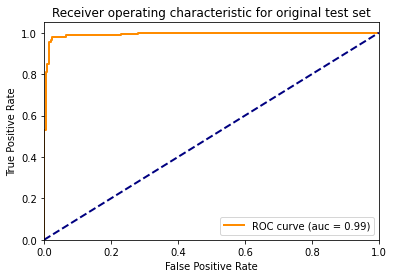

Orignal test accuracy is  0.9725
Orignal test auc is  0.99285
Orignal test precision is  0.9655172413793104
Orignal test recall is  0.98
Orignal test f1 score is  0.9727047146401985


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
# model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)
model.load_weights("bert_news.h5")

# predict on test set
predictions = model.predict(data.test_x)
predictions = predictions[:,1]
test_df['pred'] = predictions
# average the prediction to become final prediction of original test set
test['avg_pred'] = test_df.groupby(['index'])['pred'].mean()

# plot ROC curve
fpr, tpr, _ = roc_curve(test['label'], test['avg_pred'])
roc_auc = auc(fpr, tpr)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for original test set')
plt.legend(loc="lower right")
plt.show()

acc = accuracy_score(test['label'], test['avg_pred'] > 0.5)
precision = precision_score(test['label'], test['avg_pred'] > 0.5)
recall = recall_score(test['label'], test['avg_pred'] > 0.5)
f1 = f1_score(test['label'], test['avg_pred']  > 0.5)

print('Orignal test accuracy is ', acc)
print('Orignal test auc is ', roc_auc)
print('Orignal test precision is ', precision)
print('Orignal test recall is ', recall)
print('Orignal test f1 score is ', f1)

In [ ]:
# As per the steps above :)

SAVED_MODEL_PATH  = "bert_news.h5"

In [ ]:
# create model and load previous weights
model = create_model(max_seq_len = data.max_seq_len)
model.load_weights(SAVED_MODEL_PATH)


bert shape (None, 319, 768)
Done loading 196 BERT weights from: .model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6a2a9bf9e8> (prefix:bert_5). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 319)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 319, 768)    

In [ ]:
def predict_new(doc, model):
    """
    Predict new document using the trained model. 

    doc: input document in format of a string
    """

    # clean the text
    doc = clean_txt(doc)
    # split the string text into list of subtexts
    doc = get_split(doc)
    # tokenize the subtexts as well as padding 
    tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
    pred_tokens = map(tokenizer.tokenize, doc)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))
    
    # create model and load previous weights
    # model = create_model(max_seq_len = data.max_seq_len)
    # model.load_weights()

    # predict the subtexts and average the prediction
    predictions = model.predict(pred_token_ids)
    predictions = predictions[:,1]
    avg_pred = predictions.mean()
    if avg_pred > 0.5:
      doc_label = 'fake'
    else:
      doc_label = 'Real'

    return doc_label, avg_pred



In [ ]:
# Run an example text from original test set
fake_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")
doc = fake_test['text'][7]
print('----------------------NEWS -----------------------')
print(doc)
doc_label, avg_pred = predict_new(doc, model)
print()
print('---------------- PREDICTION RESULTS --------------')
print('The predicted probability of news being FAKE is ', avg_pred)
print('CLASSIFICATION : The predicted label of news is ', doc_label.upper())

----------------------NEWS -----------------------
Elena Malysheva, the famous Russian presenter and presenter, has shed some nutrients that can boost the body's immunity to fight infection with the Corona virus.
World - Europe
During one of her televised medical programs, Malysheva said: "Food products that contain large amounts of zinc are necessary to activate the so-called killer cells in the body. These cells, according to doctor Andre Prodius, are tasked with killing other cells infected with the virus."
The doctor indicated that a person can get this important component from different foods such as shellfish, oats and corn flakes.
According to Malysheva, the elderly with diabetes are among the most at risk of corona, due to the symptoms that may cause zinc deficiency in their bodies, which may affect the work of their immune system.
The doctor advised those suffering from cardiovascular diseases and cancer patients to add the Brazilian nuts to their diet as it contains selenium,